# Influence of the reference cell type

We look at how the selection of the reference cell type influences scCODA's results.
To this end, we compare the healthy and non-infalmed samples from the ulcerative colitis Lamina propria data of Smillie et al. (2019).

For each cell type, we perform one run of scCODA with this cell type set as the reference.

In [1]:
# Setup
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import anndata as ad

from sccoda.util import comp_ana as mod
from sccoda.util import data_visualization as viz


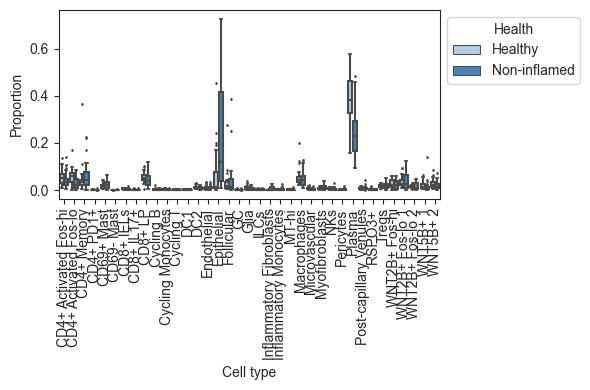

In [26]:
# read data
data_smillie_lp = ad.read_h5ad("../../sccoda_benchmark_data/smillie_lp.h5ad")

lp_h_n = data_smillie_lp[data_smillie_lp.obs["Health"].isin(["Healthy", "Non-inflamed"])]
viz.boxplots(lp_h_n, "Health")
plt.show()

In [27]:
cell_types = lp_h_n.var.index
print(cell_types)

results_reference_2 = {}

for ct in cell_types:
    print(ct)

    model_ = mod.CompositionalAnalysis(
        data=lp_h_n,
        formula="C(Health, Treatment('Healthy'))",
        reference_cell_type=ct
    )
    res_ = model_.sample_hmc()
    results_reference_2[ct] = res_

Trying to set attribute `.X` of view, copying.


Index(['CD4+ Activated Fos-hi', 'CD4+ Activated Fos-lo', 'CD4+ Memory',
       'CD4+ PD1+', 'CD69+ Mast', 'CD69- Mast', 'CD8+ IELs', 'CD8+ IL17+',
       'CD8+ LP', 'Cycling B', 'Cycling Monocytes', 'Cycling T', 'DC1', 'DC2',
       'Endothelial', 'Epithelial', 'Follicular', 'GC', 'Glia', 'ILCs',
       'Inflammatory Fibroblasts', 'Inflammatory Monocytes', 'MT-hi',
       'Macrophages', 'Microvascular', 'Myofibroblasts', 'NKs', 'Pericytes',
       'Plasma', 'Post-capillary Venules', 'RSPO3+', 'Tregs', 'WNT2B+ Fos-hi',
       'WNT2B+ Fos-lo 1', 'WNT2B+ Fos-lo 2', 'WNT5B+ 1', 'WNT5B+ 2'],
      dtype='object', name='LP_test')
CD4+ Activated Fos-hi
Zero counts encountered in data! Added a pseudocount of 0.5.
MCMC sampling finished. (65.300 sec)
Acceptance rate: 61.1%
CD4+ Activated Fos-lo
MCMC sampling finished. (64.806 sec)
Acceptance rate: 54.5%
CD4+ Memory
MCMC sampling finished. (66.085 sec)
Acceptance rate: 82.5%
CD4+ PD1+
MCMC sampling finished. (66.109 sec)
Acceptance rate: 66.9%
C

Putting it all together, we get a matrix with the columns denoting different reference cell types, and the rows showing the affected cell types

In [32]:
effect_ref_2 = pd.DataFrame(columns=cell_types, index=cell_types)

for ct in cell_types:

    res = results_reference_2[ct]
    _, edf = res.summary_prepare(est_fdr=0.05)
    effects = edf.reset_index(level=0)["Final Parameter"]
    effects[ct] = np.nan
    effect_ref_2.loc[:, ct] = effects

print(effect_ref_2)

LP_test                   CD4+ Activated Fos-hi  CD4+ Activated Fos-lo  \
LP_test                                                                  
CD4+ Activated Fos-hi                       NaN              -0.475664   
CD4+ Activated Fos-lo                 -0.990662                    NaN   
CD4+ Memory                            0.000000               0.000000   
CD4+ PD1+                             -0.980361               0.000000   
CD69+ Mast                             0.000000               0.000000   
CD69- Mast                             0.000000               0.000000   
CD8+ IELs                              0.000000               0.000000   
CD8+ IL17+                             0.000000               0.000000   
CD8+ LP                               -0.641055              -0.487800   
Cycling B                             -0.782202               0.000000   
Cycling Monocytes                     -0.815659              -0.510728   
Cycling T                             

For visualization, lets plot a heatmap. We see that most results are very consistent.
If we take one of the strongly decreasing cell types (as found in the other runs) as the reference,
we get less negative effects. Taking Epithelial cells, the only increasing cell type, as the reference gives us the largest number of negative effects.

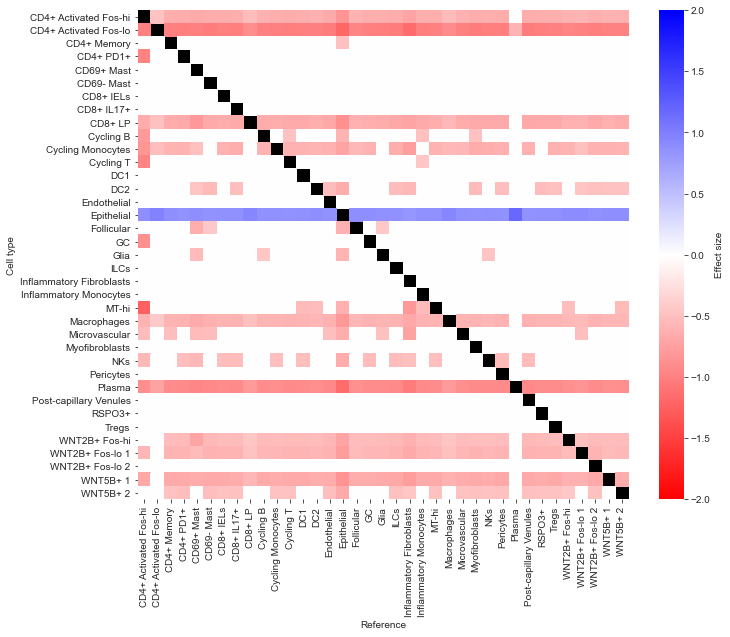

In [37]:
fig, ax = plt.subplots(figsize=(11, 9))
g = sns.heatmap(
    effect_ref_2,
    vmin=-2,
    vmax=2,
    cmap="bwr_r",
    cbar=True,
    cbar_kws={"label": "Effect size"}
)
g.set_facecolor('black')

plt.xlabel("Reference")
plt.ylabel("Cell type")

plot_path = "../../sccoda_benchmark_data/paper_plots_rv1/"
plt.savefig(plot_path + "/reference_selection_smillie_lp_h_n.svg", format="svg", bbox_inches="tight")
plt.savefig(plot_path + "/reference_selection_smillie_lp_h_n.png", format="png", bbox_inches="tight")

plt.show()